In [113]:
%pylab inline

import pandas as pd

import xgboost as xgb

from sklearn.metrics import auc, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split

rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [181]:
df = pd.read_csv('data/creditcard.csv')

In [182]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [183]:
X = df[['V{}'.format(idx) for idx in range(1,29)]]
y = df['Class']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [167]:
mdl = xgb.XGBClassifier(use_label_encoder=False, learning_rate=0.30, max_depth=6, n_jobs=16, n_estimators=100)

import ipywidgets as widgets
loading = widgets.IntProgress(value=0, min=0, max=mdl.n_estimators, step=1, description='Training:')
display(loading)

class Progress(xgb.callback.TrainingCallback):
    def __init__(self):
        pass

    def _get_key(self, data, metric):
        return f'{data}-{metric}'

    def after_iteration(self, model, epoch, evals_log):
        loading.value = epoch
        return False

a = time.time()
mdl.fit(X_train, y_train, eval_metric='aucpr', eval_set=[(X_train, y_train), (X_test, y_test)], 
        callbacks=[Progress()], verbose=False)
b = time.time()
print('ran in {:.1f} seconds'.format(b-a))

IntProgress(value=0, description='Training:')

ran in 28.0 seconds


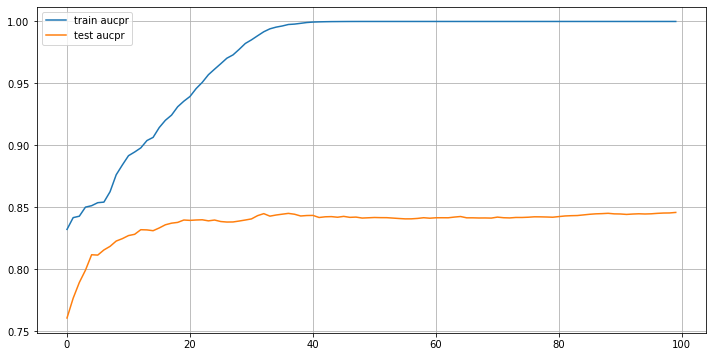

In [168]:
figsize(12,6)
plot(mdl.evals_result()['validation_0']['aucpr'], label='train aucpr')
plot(mdl.evals_result()['validation_1']['aucpr'], label='test aucpr')
legend(loc='upper left')

In [169]:
auc(*precision_recall_curve(y_test, mdl.predict(X_test))[:2][::-1])

0.88319418099283

In [170]:
precision_recall_curve(y_test, mdl.predict(X_test))

(array([0.00159172, 0.96460177, 1.        ]),
 array([1.        , 0.80147059, 0.        ]),
 array([0, 1]))

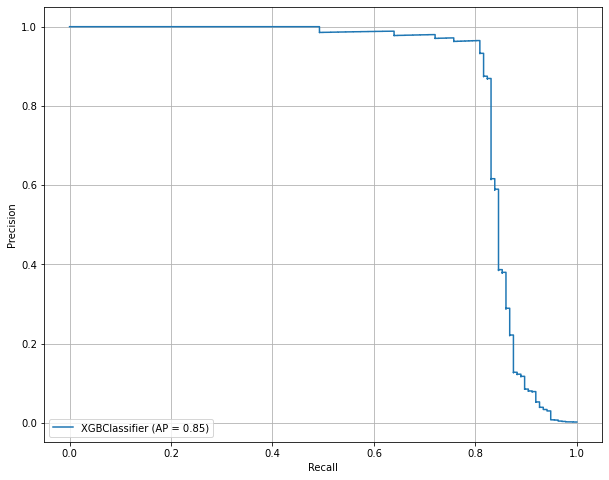

In [171]:
"""
                Data
                positive   negative
Model positive  true pos   false pos 
      negative  false neg  true neg

Precision = (true pos) / (true pos + false pos)
High precision means few false positives. "X% of all positive predictions were true positives"

Recall = Sensitivity = (true pos) / (true pos + false neg)
High recall means few false negatives. "X% of all positives were predicted as positive" 
"""

figsize(10,8)
plot_precision_recall_curve(mdl, X_test, y_test)